In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tools.plotting import lag_plot
%matplotlib inline
%precision 4
from ipywidgets import widgets
from IPython.display import display
plt.style.use('ggplot')
import pystan
import util
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 50)
util.scale_plot_size(1.5)

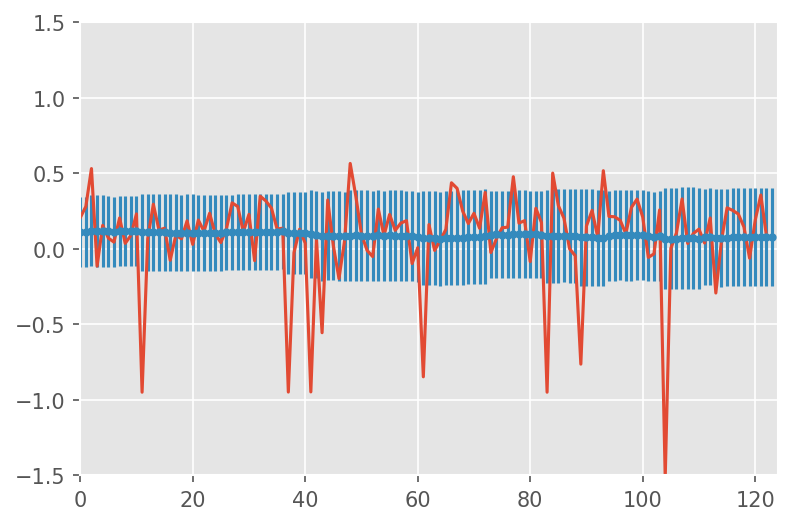

In [20]:
plot_series(['30925', '2016-5-4', '2016-6-30', 'Off the Tee'])

In [18]:
categories = ['Off the Tee', 'Approach to the Green', 'Around the Green', 'Putting']
def plot_series(params):
    sqlTxt = '''
    select strokes_gained_baseline 
      from strokes 
     where player_id = %s 
       and date > %s
       and date < %s
       and strokes_gained_category LIKE %s
       order by date, time;
    '''
    sg = util.pd_from_sql(sqlTxt, params)
    window = 100
    rolling = sg.rolling(window).mean().as_matrix()[window:]
    std_roll = sg.rolling(window).std().as_matrix()[window:]
    sg = sg[window:]
    plt.plot(range(0, len(sg)), sg)
    foo = plt.errorbar(range(0, len(rolling)), rolling, std_roll, linestyle=None, marker=".")
    plt.axis([0, len (sg), -1.5, 1.5])

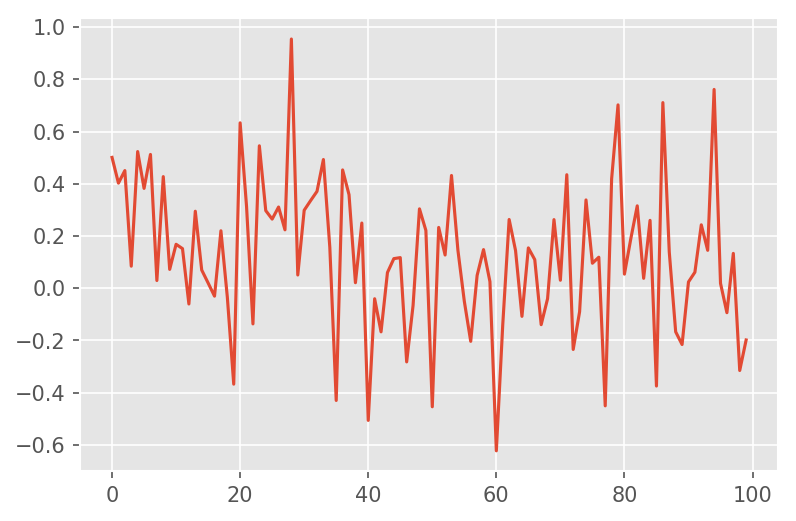

In [27]:
sqlTxt = '''
select * from stats_view where year = 2014 limit 100;
  
'''
df = util.pd_from_sql(sqlTxt)
# foo = plt.errorbar(range(0, len (df)), df['avg_score'], df['std_score'], linestyle='None', marker='^')
plt.plot(range(0, len (df)), df['avg_sg_putting'])

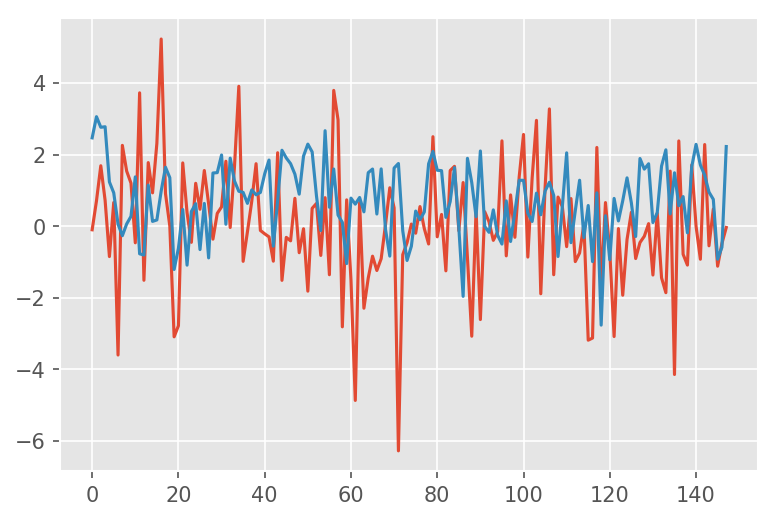

In [41]:

sqlTxt = '''
select * from scores where player_id = 24502 order by date;
  
'''
df = util.pd_from_sql(sqlTxt)
# foo = plt.errorbar(range(0, len (df)), df['avg_score'], df['std_score'], linestyle='None', marker='^')
plt.plot(range(0, len (df)), df['sg_putting'])
plt.plot(range(0, len (df)), df['sg_tee'])

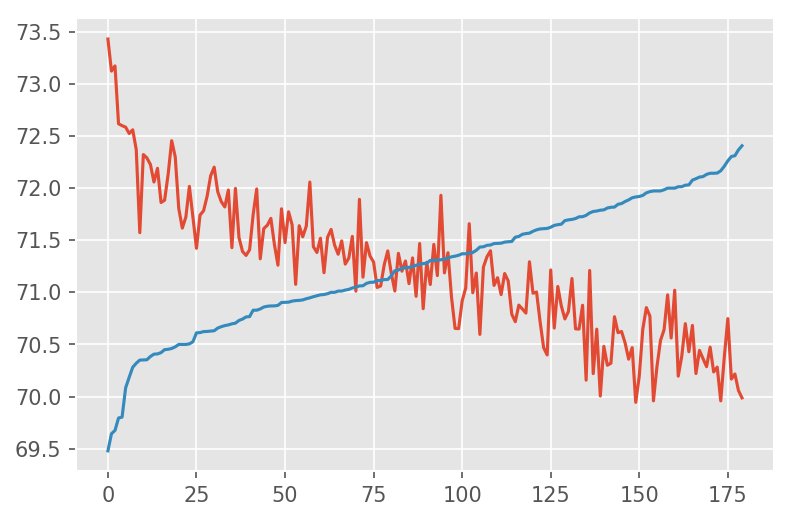

In [47]:

sqlTxt = '''
select avg_score, avg_sg_tee + avg_sg_approach + avg_sg_around + avg_sg_putting as avg_sg from stats_view limit 180
'''
df = util.pd_from_sql(sqlTxt)
# foo = plt.errorbar(range(0, len (df)), df['avg_score'], df['std_score'], linestyle='None', marker='^')
plt.plot(range(0, len (df)), df['avg_sg'] + 71)
plt.plot(range(0, len (df)), df['avg_score'])